In [1]:
import numpy as np
import pandas as pd
import warnings
from scipy.stats import chi2_contingency
from scipy import stats
from matplotlib import pyplot as plt
import json
import yapf.yapflib.yapf_api
from sklearn.utils import shuffle
warnings.filterwarnings("ignore")

1 Read the dataset 
========

In [2]:
maindata= pd.read_csv('../DATASET_2019-10-24_light.txt',sep=',')

In [3]:
class0=maindata[maindata.CLASS==0]
class1=maindata[maindata.CLASS==1]
class0=class0.sample(class1.shape[0],random_state=42)
data=pd.concat([class1,class0])
print(data.shape)

data.groupby(by='CLASS').size()

(9482, 407)


CLASS
0    4741
1    4741
dtype: int64

In [4]:

data['FIELD_6_7']=np.min(data[['FIELD_6','FIELD_7']],axis=1) #combine FIELD_6 and FIELD_7 both represent the same thing (Women's marital status)
data=data.drop(columns=['FIELD_6','FIELD_7','COMPARE','B_DAY','Unnamed: 0'])#,'FIELD_1','FIELD_2'
print(data.shape)

(9482, 403)


In [5]:
# # filter the data set
# data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
# data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

# data = data[
#     data.FIELD_15 != 1
# ]  # exclude people who are diagnosed for (high blood pressure)
# data = data[
#     data.FIELD_22 != 1
# ]  # exclude people who are on medication for high blood pressure

# data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
# data = data[
#     data.FIELD_24 != 1
# ]  # exclude people who are on medication for hyperlipidemia

# data = data[data.FIELD_13 != 1]  
# data = data[data.FIELD_20 != 1]  

# print(data.shape)

In [6]:
# rename columns
data.rename(
    columns={
        "L104600": "HBA1C",
        "L103000": "Triglycerides",
        "L100800": "fasting glucose",
        "S000300": "BMI",
        "S000501": "SBP",
        "S000502": "DBP",
        "L101700": "r-GTP gamma",
        "L103300": "Cardiac risk factor",
        "L190400": "Hemoglobin",
        "L190500": "HCT",
        "L100700": "Uric Acid",
        "L101300": "SGPT",
        "L190300": "RBC",
        "L102900": "total cholesterol",
        "L103100": "HDL-Cholesterol",
    },
    inplace=True,
)

In [7]:
# split column types to categorical and numerical
numerical_cols = list(data.columns[~data.columns.str.startswith("FIELD")])
categorical_cols = list(data.columns[data.columns.str.startswith("FIELD")])
categorical_cols.append("CLASS")
numerical_cols.remove("SEX")
categorical_cols.append("SEX")

In [8]:
print(data.shape)
print(data.groupby(by='CLASS').size())

(9482, 403)
CLASS
0    4741
1    4741
dtype: int64


In [9]:
# print(data.shape)
# print(data.groupby(by='CLASS').size())

# mydata=data.copy()
# class1 = mydata[mydata.CLASS == 1]
# class0 = mydata[mydata.CLASS == 0]

# data = pd.concat([class1.sample(class0.shape[0],random_state=42), 
#                   class0])

# print(data.shape)

2 Feature Selection
===========

2.1 Calculate correlation Value - for numerical values
========

2.1.1 Pearson Correlation
======

In [11]:
corr = data[numerical_cols].corr()  # compute the correlation value
corr = corr.CLASS  # select the correlation values of the Class

# convert correlation values to dataframe
corrvalPD = pd.DataFrame()
corrvalPD["Col"] = corr.index
corrvalPD["val"] = abs(corr.values)

corrvalPD = corrvalPD.sort_values(by="val", ascending=False)
corrvalPD.head()

,Col,val
272,CLASS,1.000000
148,L501900,1.000000
130,L394600,1.000000
120,L336400,1.000000
197,L573706,0.654654


In [12]:
# get count of none NA values of each feature set
mydataset = data.copy()[numerical_cols]
colCount = []
for i in mydataset.columns:
    colCount.append([i, mydataset[i].dropna().shape[0]])

colCountPD = pd.DataFrame(colCount, columns=["Col", "Count"])
colCountPD.head()

,Col,Count
0,AGE,9482
1,L100100,8950
2,L100200,8965
3,L100300,8766
4,L100400,8964


In [47]:
# merge the correlation value and the total count of the feature
mergedColCorrCount = pd.merge(
    corrvalPD, colCountPD, how="inner", left_on="Col", right_on="Col"
)
mergedColCorrCount = mergedColCorrCount[mergedColCorrCount.Count > 8000]
mergedColCorrCount = mergedColCorrCount.sort_values(by="val", ascending=False)
mergedColCorrCount.head(20)

,Col,val,Count
0,CLASS,1.000000,9482
12,AGE,0.303084,9482
22,SBP,0.192203,9479
23,BMI,0.185966,9468
26,DBP,0.167178,9479
29,L100400,0.165281,8964
40,L105200,0.143982,9466
45,fasting glucose,0.134443,9475
51,Hemoglobin,0.123223,9475
52,L100500,0.122320,9469


In [48]:
# select top 20 correlated features
print(list(mergedColCorrCount.head(16).Col))

['CLASS', 'AGE', 'SBP', 'BMI', 'DBP', 'L100400', 'L105200', 'fasting glucose', 'Hemoglobin', 'L100500', 'L101200', 'L504700', 'HDL-Cholesterol', 'HCT', 'RBC', 'Uric Acid']


2.1.2 Anova test
=======

In [49]:
# another option for feature selection of numerical values

mydataset = data.copy()[numerical_cols]  # filter only numrical columns
colslist = mydataset.columns
DiabeticColVals = mydataset.CLASS

cor = []
pval = []
count = []

# for each column compute f and p values
for i in range(len(colslist)):

    temp = pd.DataFrame([])
    temp["a"] = DiabeticColVals
    temp["b"] = mydataset[colslist[i]]
    temp = temp.dropna()

    count.append(temp.shape[0])
    tempcor = temp.corr()

    if tempcor.shape[0] > 1:
        F, p = stats.f_oneway(
            temp[temp["a"] == 0].b, temp[temp["a"] == 1].b
        )
        cor.append(F)
        pval.append(p)
    else:
        cor.append(0)
        pval.append(0)

In [50]:
FvalPvalCorr = pd.DataFrame()
FvalPvalCorr["Cols"] = colslist
FvalPvalCorr["F"] = cor
FvalPvalCorr["P"] = pval
FvalPvalCorr["Count"] = count
FvalPvalCorr = FvalPvalCorr.sort_values(by="F", ascending=False)

In [51]:
# select top 20 features
print(list(FvalPvalCorr[FvalPvalCorr.Count > 7000].Cols)[:25])
FvalPvalCorr[FvalPvalCorr.Count > 7000].head(20)

['CLASS', 'AGE', 'SBP', 'BMI', 'DBP', 'L100400', 'L101400', 'L105200', 'fasting glucose', 'Hemoglobin', 'L100500', 'L101200', 'HDL-Cholesterol', 'HCT', 'S001908', 'L504700', 'RBC', 'r-GTP gamma', 'Uric Acid', 'L190000', 'SGPT', 'L101600', 'Cardiac risk factor', 'Triglycerides', 'L190900']


,Cols,F,P,Count
272,CLASS,inf,0.000000e+00,9482
0,AGE,958.916344,1.192206e-200,9482
210,SBP,363.528215,1.465125e-79,9479
208,BMI,339.093881,1.986199e-74,9468
211,DBP,272.484178,2.261031e-60,9479
4,L100400,251.696836,6.367100e-56,8964
12,L101400,203.402086,1.367314e-45,7990
40,L105200,200.350357,5.035203e-45,9466
7,fasting glucose,174.374579,1.828165e-39,9475
89,Hemoglobin,146.054201,2.222345e-33,9475


2.2 Correlation for categorical values
============

2.2.1 chi2 method
=====

In [10]:
# rename commen field names
categorical_cols[categorical_cols.index("FIELD_33")] = "_4_1_Smoking"
categorical_cols[categorical_cols.index("FIELD_38")] = "Drinking_5_1_days"
categorical_cols[
    categorical_cols.index("FIELD_40")
] = "_6_1_of_physical_activity_high_strength"
categorical_cols[categorical_cols.index("FIELD_31")] = "Family_history"
categorical_cols[
    categorical_cols.index("FIELD_41")
] = "_6_2_of_physical_activity_moderate"
categorical_cols[categorical_cols.index("FIELD_27")] = "_2_family_history_stroke"
categorical_cols[categorical_cols.index("FIELD_21")] = "_1_medication_heart_disease"
categorical_cols[categorical_cols.index("FIELD_14")] = "Whether_one_diagnosis_disease"
categorical_cols[categorical_cols.index("FIELD_32")] = "_3B_hepatitis"
categorical_cols[
    categorical_cols.index("FIELD_42")
] = "_6_3_of_physical_activity_walking"
categorical_cols[categorical_cols.index("FIELD_4")] = "blood_type"
categorical_cols[categorical_cols.index("FIELD_29")] = "_2_family_history_hypertension"
categorical_cols[categorical_cols.index("FIELD_3")] = "Blood_factor_RH_factor"
categorical_cols[categorical_cols.index("FIELD_19")] = "_1_drug_therapy_stroke"

In [11]:
mydata = data.rename(
    columns={
        "FIELD_33": "_4_1_Smoking",
        "FIELD_38": "Drinking_5_1_days",
        "FIELD_40": "_6_1_of_physical_activity_high_strength",
        "FIELD_31": "Family_history",
        "FIELD_41": "_6_2_of_physical_activity_moderate",
        "FIELD_27": "_2_family_history_stroke",
        "FIELD_21": "_1_medication_heart_disease",
        "FIELD_14": "Whether_one_diagnosis_disease",
        "FIELD_32": "_3B_hepatitis",
        "FIELD_42": "_6_3_of_physical_activity_walking",
        "FIELD_4": "blood_type",
        "FIELD_29": "_2_family_history_hypertension",
        "FIELD_3": "Blood_factor_RH_factor",
        "FIELD_19": "_1_drug_therapy_stroke",
    },
    inplace=True,
)


# mydata=data[categorical_cols] # filter only categorical columns

In [12]:
# filter only categorical columns
mydata = data[categorical_cols]
# remove columns with string values as data type
mydata = mydata.drop(
    columns=[
        "FIELD_8",
        "FIELD_10",
        "FIELD_11",
        "FIELD_12",
        "FIELD_39",'FIELD_37',
        "FIELD_88",
        "FIELD_89",
        "FIELD_109",
        "FIELD_110",
        "FIELD_111",
        "FIELD_70",
        "FIELD_82",
        "FIELD_85",
        "FIELD_91",
        "FIELD_103",
        "FIELD_106",
    ]
)

mydata.head()

,FIELD_1,FIELD_2,Blood_factor_RH_factor,blood_type,FIELD_5,FIELD_9,FIELD_13,Whether_one_diagnosis_disease,FIELD_15,FIELD_16,...,FIELD_134,FIELD_135,FIELD_136,FIELD_137,FIELD_138,FIELD_139,FIELD_140,FIELD_6_7,CLASS,SEX
196,1000482,20141104,NaN,3,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
501,1001277,20130115,NaN,1,1,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
539,1001450,20150819,NaN,1,2,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
633,1001642,20140226,1,2,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
699,1001799,20180421,1,2,NaN,NaN,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0


In [21]:
# Data clean up
mydata = mydata.drop(
    mydata[["Blood_factor_RH_factor"]][mydata[["Blood_factor_RH_factor"]] == "`"]
    .dropna()
    .index
)
mydata = mydata.drop(
    mydata[["Blood_factor_RH_factor"]][mydata[["Blood_factor_RH_factor"]] == "G"]
    .dropna()
    .index
)

mydata = mydata.drop(
    mydata[["blood_type"]][mydata[["blood_type"]] == "."].dropna().index
)
mydata = mydata.drop(mydata[mydata.FIELD_5 == "."].index)


mydata = mydata.drop(mydata[mydata.FIELD_35 == "?"].index)
mydata = mydata.drop(mydata[mydata.FIELD_35 == "."].index)
mydata = mydata.drop(mydata[mydata.FIELD_36 == "."].index)
# mydata = mydata.drop(mydata[mydata.FIELD_37 == "\\"].index)
mydata.head()

# mydata=mydata.drop(mydata[mydata.FIELD_39 == '7+' ].index)
# mydata=mydata.drop(mydata[mydata.FIELD_39 == '5~7'].index)
# mydata=mydata.drop(mydata[mydata.FIELD_39 == '3-4'].index)


mydata = mydata.drop(mydata[mydata.FIELD_95 == "."].index)
mydata.head()

mydata.head()

,FIELD_1,FIELD_2,Blood_factor_RH_factor,blood_type,FIELD_5,FIELD_9,FIELD_13,Whether_one_diagnosis_disease,FIELD_15,FIELD_16,...,FIELD_134,FIELD_135,FIELD_136,FIELD_137,FIELD_138,FIELD_139,FIELD_140,FIELD_6_7,CLASS,SEX
196,1000482,20141104,NaN,3,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
501,1001277,20130115,NaN,1,1,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
539,1001450,20150819,NaN,1,2,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
633,1001642,20140226,1,2,NaN,NaN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
699,1001799,20180421,1,2,NaN,NaN,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0


In [22]:
AllTables = []

# prepare the table indicating the number of entries per class and per each column group
for j in range(len(mydata.columns)):

    columnName = mydata.columns[j]
    print(j, columnName)

    temp = mydata[columnName].dropna().astype(float).unique()
    mytempdata = mydata[[columnName, "CLASS"]].dropna()
    mytempdata[columnName] = mytempdata[columnName].astype(float)
    temptable = []

    sumval = 0

    for i in range(temp.shape[0]):

        temp_i_val = str(temp[i])
        class0_count = mytempdata.query(
            columnName + " == " + (temp_i_val) + " & CLASS == 0"
        ).shape[0]
        class1_count = mytempdata.query(
            columnName + " == " + (temp_i_val) + " & CLASS == 1"
        ).shape[0]

        sumval = sumval + (class0_count + class1_count)

        temptable.append([class0_count, class1_count])

    #     print(sumval,mytempdata.shape[0], mytempdata.shape[0] == sumval)

    if len(temptable) > 1:
        AllTables.append([temptable, columnName, mytempdata.shape[0]])

0 FIELD_1
1 FIELD_2
2 Blood_factor_RH_factor
3 blood_type
4 FIELD_5
5 FIELD_9
6 FIELD_13
7 Whether_one_diagnosis_disease
8 FIELD_15
9 FIELD_16
10 FIELD_17
11 FIELD_18
12 _1_drug_therapy_stroke
13 FIELD_20
14 _1_medication_heart_disease
15 FIELD_22
16 FIELD_23
17 FIELD_24
18 FIELD_25
19 FIELD_26
20 _2_family_history_stroke
21 FIELD_28
22 _2_family_history_hypertension
23 FIELD_30
24 Family_history
25 _3B_hepatitis
26 _4_1_Smoking
27 FIELD_34
28 FIELD_35
29 FIELD_36
30 Drinking_5_1_days
31 _6_1_of_physical_activity_high_strength
32 _6_2_of_physical_activity_moderate
33 _6_3_of_physical_activity_walking
34 FIELD_43
35 FIELD_44
36 FIELD_45
37 FIELD_46
38 FIELD_47
39 FIELD_48
40 FIELD_49
41 FIELD_50
42 FIELD_51
43 FIELD_52
44 FIELD_53
45 FIELD_54
46 FIELD_55
47 FIELD_56
48 FIELD_57
49 FIELD_58
50 FIELD_59
51 FIELD_60
52 FIELD_61
53 FIELD_62
54 FIELD_63
55 FIELD_64
56 FIELD_65
57 FIELD_66
58 FIELD_67
59 FIELD_68
60 FIELD_69
61 FIELD_72
62 FIELD_73
63 FIELD_74
64 FIELD_75
65 FIELD_76
66 FIELD

In [23]:
# compute the statisitical values
statas = []
for i in range(len(AllTables)):
    #     print(i,AllTables[i][1])
    table = AllTables[i][0]
    stat, p, dof, expected = chi2_contingency(table)
    statas.append(
        [
            AllTables[i][1],
            stat,
            p,
            dof,
            np.sum(table),
            AllTables[i][2],
            AllTables[i][1],
            table,
            expected,
        ]
    )

In [24]:
# convert the computed status to dataframe
finalstat = pd.DataFrame(
    statas,
    columns=[
        "Name",
        "stat",
        "p",
        "dof",
        "instances",
        "orginal",
        "Name2",
        "table",
        "expected",
    ],
)
finalstat = finalstat[
    finalstat.orginal > 7000
]  # select columns with count at least 200, 000

# sort stat value and select top 20 features
finalstat.stat = finalstat.stat.astype(int)
finalstat = finalstat.sort_values(by="stat", ascending=False)

print(list(finalstat.Name[:15]))
finalstat[["Name", "stat", "instances"]].head(10)

['CLASS', 'FIELD_1', 'FIELD_2', 'FIELD_15', 'FIELD_22', 'Whether_one_diagnosis_disease', '_1_medication_heart_disease', '_4_1_Smoking', 'SEX', 'FIELD_23', 'FIELD_16', '_6_3_of_physical_activity_walking', '_2_family_history_stroke', 'FIELD_24', 'FIELD_17']


,Name,stat,instances
106,CLASS,9478,9482
0,FIELD_1,9384,9482
1,FIELD_2,1982,9482
8,FIELD_15,434,9457
15,FIELD_22,426,9380
7,Whether_one_diagnosis_disease,325,9450
14,_1_medication_heart_disease,259,9356
26,_4_1_Smoking,115,9438
107,SEX,107,9482
16,FIELD_23,102,9371


3 Refine the selected numerical and categorical features
====

In [25]:
data.shape

(9482, 403)

In [52]:
# combine the selected columns list from section 2.1.2 and 2.2.1

newColList = [
    'AGE', 'SBP', 'BMI', 'DBP', 'L100400', 'L101400', 'L105200', 'fasting glucose', 'Hemoglobin', 'L100500', 
    'L101200', 'HDL-Cholesterol', 'HCT', 'S001908', 'L504700', 'RBC', 'r-GTP gamma', 'Uric Acid', 'L190000', 
    'SGPT', 'L101600', 'Cardiac risk factor', 'Triglycerides', 'L190900','FIELD_15', 'FIELD_22', 
    'Whether_one_diagnosis_disease', '_1_medication_heart_disease', '_4_1_Smoking', 'SEX', 
    'FIELD_16', 'FIELD_23', '_6_3_of_physical_activity_walking', '_2_family_history_stroke', 
    'FIELD_24', 'FIELD_17', 'blood_type', '_6_2_of_physical_activity_moderate',
    "CLASS"
]

In [53]:
# mydata = data[newColList].copy()
# for i in mydata.columns:
# #     if(mydata[i].dropna().shape[0] < 100000):
#     print(i,mydata[i].dropna().shape[0])

# print(mydata.dropna().shape[0])

# mydata.head()

In [54]:
# filter a new data based on the selected columns
mydata = data[newColList].copy().dropna()

print(mydata.shape)
mydata.head()


(5149, 39)


,AGE,SBP,BMI,DBP,L100400,L101400,L105200,fasting glucose,Hemoglobin,L100500,...,SEX,FIELD_16,FIELD_23,_6_3_of_physical_activity_walking,_2_family_history_stroke,FIELD_24,FIELD_17,blood_type,_6_2_of_physical_activity_moderate,CLASS
501,46.0,106.0,25.4,69.0,13.4,265.0,85.0,94.0,15.2,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1
633,47.0,156.0,29.2,98.0,10.8,278.0,68.0,111.0,16.2,1.2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,1.0,1
1050,47.0,115.0,24.7,67.0,10.6,300.0,85.0,86.0,15.2,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,1.0,1
1759,49.0,138.0,28.4,92.0,20.2,404.0,75.0,107.0,14.7,1.1,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2,1.0,1
1906,48.0,170.0,23.4,110.0,10.2,384.0,81.0,81.0,11.8,0.8,...,1.0,0.0,0.0,7.0,0.0,0.0,0.0,1,5.0,1


In [55]:
x = mydata[
    [
    'AGE', 'SBP', 'BMI', 'DBP', 'L100400', 'L101400', 'L105200', 'fasting glucose', 'Hemoglobin', 'L100500', 
    'L101200', 'HDL-Cholesterol', 'HCT', 'S001908', 'L504700', 'RBC', 'r-GTP gamma', 'Uric Acid', 'L190000', 
    'SGPT', 'L101600', 'Cardiac risk factor', 'Triglycerides', 'L190900','FIELD_15', 'FIELD_22', 
    'Whether_one_diagnosis_disease', '_1_medication_heart_disease', '_4_1_Smoking', 'SEX', 
    'FIELD_16', 'FIELD_23', '_6_3_of_physical_activity_walking', '_2_family_history_stroke', 
    'FIELD_24', 'FIELD_17', 'blood_type', '_6_2_of_physical_activity_moderate'
    ]
]


y = mydata[["CLASS"]]

print(x.shape)
mydata.head()

(5149, 38)


,AGE,SBP,BMI,DBP,L100400,L101400,L105200,fasting glucose,Hemoglobin,L100500,...,SEX,FIELD_16,FIELD_23,_6_3_of_physical_activity_walking,_2_family_history_stroke,FIELD_24,FIELD_17,blood_type,_6_2_of_physical_activity_moderate,CLASS
501,46.0,106.0,25.4,69.0,13.4,265.0,85.0,94.0,15.2,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1
633,47.0,156.0,29.2,98.0,10.8,278.0,68.0,111.0,16.2,1.2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,1.0,1
1050,47.0,115.0,24.7,67.0,10.6,300.0,85.0,86.0,15.2,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,1.0,1
1759,49.0,138.0,28.4,92.0,20.2,404.0,75.0,107.0,14.7,1.1,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2,1.0,1
1906,48.0,170.0,23.4,110.0,10.2,384.0,81.0,81.0,11.8,0.8,...,1.0,0.0,0.0,7.0,0.0,0.0,0.0,1,5.0,1


3.1 ExtraTreesClassifier feature_importances method
========================

[0.06448435 0.03563279 0.03773823 0.03732216 0.03249255 0.0331858
 0.03612108 0.03102855 0.02824447 0.02552585 0.03090788 0.03069912
 0.02868011 0.02277238 0.03546419 0.03030698 0.03007289 0.03188816
 0.0328716  0.03030839 0.03100411 0.03142603 0.03188408 0.03123
 0.0258838  0.01486313 0.0103912  0.01665238 0.01815451 0.01185655
 0.00561752 0.00529789 0.02960859 0.00961988 0.00337974 0.00377367
 0.02750882 0.02610058]


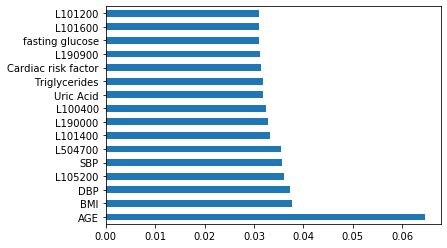

Index(['AGE', 'BMI', 'DBP', 'L105200', 'SBP', 'L504700', 'L101400', 'L190000',
       'L100400', 'Uric Acid', 'Triglycerides', 'Cardiac risk factor',
       'L190900', 'fasting glucose', 'L101600', 'L101200', 'HDL-Cholesterol'],
      dtype='object')


In [56]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(x, y)

print(
    model.feature_importances_
)  # use inbuilt class feature_importances of tree based classifiers

# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(17).index)

3.2 SelectKBest method
=========

In [57]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(x, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ["Specs", "Score"]  # naming the dataframe columns

# x=x[x.columns[:15]]
print(list(x.columns[:20]))

['AGE', 'SBP', 'BMI', 'DBP', 'L100400', 'L101400', 'L105200', 'fasting glucose', 'Hemoglobin', 'L100500', 'L101200', 'HDL-Cholesterol', 'HCT', 'S001908', 'L504700', 'RBC', 'r-GTP gamma', 'Uric Acid', 'L190000', 'SGPT']


3.3 variance inflation factor 
=============

In [58]:
# this function computes vif value which help us to remove columns with redundant information ( to avoid Multicollinearity)
# Multicollinearity occurs when two or more predictors in the model are correlated and provide redundant information about the response.
# Multicollinearity was measured by variance inflation factors (VIF) and tolerance


def vifcal(inputdata, depcol):
    vifL5 = []
    import statsmodels.formula.api as sm

    xvars = inputdata.drop([depcol], axis=1)
    xvarnames = xvars.columns
    for i in range(0, xvarnames.shape[0]):
        _y = xvars[xvarnames[i]]
        _x = xvars[xvarnames.drop(xvarnames[i])]
        rsq = sm.ols(formula="_y~_x", data=xvars).fit().rsquared
        vif = round(1 / (1 - rsq), 2)
        print(i, ", ", xvarnames[i], " VIF = ", vif)
        if vif < 5:
            vifL5.append(xvarnames[i])
    return vifL5

In [59]:
# # the new columns are selcted from section 3.2
# # newcols = vifcal(mydata[['L104600', 'L103000', 'S000300', 'S000501', 'S000502', 'L101700', 'L103300', 'SEX',
# #                          'L190400', 'AGE', 'L190500', 'L100700', 'L101300', 'L190300', 'L102900', 'L103100',
# #                          'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_31','CLASS']],'CLASS')

# newcols = vifcal(
#     mydata[
#         [
#             'AGE', 'L100100', #'DBP','SBP', 'HDL-Cholesterol', 
#        'Uric Acid', 'BMI', 'L100200', 'r-GTP gamma', 'fasting glucose',
#        'L101600', 'L100400', 'SGPT', 'RBC', 'Hemoglobin', 'HCT',
#         '_4_1_Smoking','SEX','Drinking_5_1_days', '_6_1_of_physical_activity_high_strength',
#             "CLASS",
#         ]
#     ],
#     "CLASS",
# )
# print(newcols, len(newcols))

# # we need to exclude features with vif value >5
# # L190400  ,L103300,L190500,L190300,L102900,L103100

3.4 Final Selected Features
======

In [13]:
# based on the out put of section of 3.2 and 3.3 the following features are selected

# finalFeatures = ['AGE', 'BMI',  'L101400', 'fasting glucose', 
#             'HDL-Cholesterol', 'HCT',   'RBC', 'r-GTP gamma', 
#             'Uric Acid', 'L190000', #'L101200', 'SGPT','SBP', 'DBP', 'L504700','S001908','L100400','L105200', 'L100500', 'Hemoglobin', 
#                  'CLASS'
# ]

# finalFeatures = ['_6_3_of_physical_activity_walking','AGE', 'BMI', 'DBP', 'L504700', 'L100400', 'SBP', 'L101400', 'L190900',
#        'HDL-Cholesterol', 'total cholesterol', 'L103200', 'L190000', 'fasting glucose', 'SGPT', 'r-GTP gamma',
#        'L105200', 'L101600',  'Uric Acid', 'Cardiac risk factor', 'Triglycerides',
#                  'CLASS'
# ]

# finalFeatures = ['AGE', 'SBP', 'BMI', 'DBP', 'L101400', 'FIELD_15', 'L100400', 'L190900',
#        'L190000', 'L105200', 'Cardiac risk factor', 'L504700', 'RBC',
#        'HDL-Cholesterol', 'Uric Acid', 'fasting glucose', 'Triglycerides',
#                  'CLASS'
# ]


# finalFeatures = ['_6_3_of_physical_activity_walking','AGE', 'BMI', 'L504700', 'L100400', 'L101400',
#                  'L190900','HDL-Cholesterol', 'total cholesterol', 'L103200', 'L190000', 'fasting glucose', 'SGPT',                 
#                  'r-GTP gamma','L105200', 'L101600',  'Uric Acid', 'Cardiac risk factor', 'Triglycerides',
#                  'DBP', 'SBP', 
#                  'CLASS'
# ]


# finalFeatures = ['_6_3_of_physical_activity_walking','AGE', 'BMI', 'L504700', 'L100400', 
#                  'L190900','L190000', 'Uric Acid',   'DBP', 'SBP', 'SEX',
#                  '_4_1_Smoking', 'Drinking_5_1_days', '_6_1_of_physical_activity_high_strength',
#                  'CLASS'
# ]

finalFeatures = ['AGE', 'BMI', 'FIELD_15', 'L190900',
                 'Cardiac risk factor', 'L504700', 'RBC',
                 'HDL-Cholesterol', 'Uric Acid', 
                 '_4_1_Smoking', 'Drinking_5_1_days', 'SEX','Triglycerides','r-GTP gamma',
#                  'SBP',  'DBP','fasting glucose', 
                 #'L101400', 'L100400', 'L190000', 'L105200', 
                 'CLASS'
]




Classifier Model Test Based on the features 
========

In [14]:
randomseed = 7
mydata = data[finalFeatures].copy().dropna()
print(mydata.shape)
mydata.head()

(6279, 15)


,AGE,BMI,FIELD_15,L190900,Cardiac risk factor,L504700,RBC,HDL-Cholesterol,Uric Acid,_4_1_Smoking,Drinking_5_1_days,SEX,Triglycerides,r-GTP gamma,CLASS
501,46.0,25.4,0.0,13.2,4.0,3.26,4.93,54.0,5.8,2.0,4.0,0.0,88.0,43.0,1
633,47.0,29.2,0.0,13.9,5.4,1.48,5.25,28.0,4.1,3.0,1.0,0.0,277.0,43.0,1
735,48.0,21.5,0.0,13.4,3.0,0.62,4.58,72.0,4.4,1.0,3.0,1.0,94.0,33.0,1
1050,47.0,24.7,0.0,13.5,3.6,0.98,4.69,55.0,4.4,1.0,2.0,0.0,124.0,44.0,1
1759,49.0,28.4,0.0,13.1,5.3,3.70,4.71,37.0,5.5,1.0,1.0,0.0,177.0,44.0,1


In [15]:
class1 = mydata[mydata.CLASS == 1]
class0 = mydata[mydata.CLASS == 0]

print(class1.shape[0],class0.shape[0],)

class1_test = class1.sample(200, random_state=42)
class0_test = class0.sample(200, random_state=42)
test = pd.concat([class1_test, class0_test])
test=shuffle(test)


class1_train = class1.drop(class1_test.index) #.sample( class2_train.shape[0], random_state=randomseed)
class0_train = class0.drop(class0_test.index) #.sample( class2_train.shape[0], random_state=randomseed)
train = pd.concat([class1_train, class0_train])
train=shuffle(train, random_state=42)

3117 3162


In [16]:
# # generate synthetic dataset to overcome class imbalance
# from collections import Counter
# from numpy.random import RandomState
# from sklearn.datasets import make_classification
# from imblearn.over_sampling import SMOTENC

# sm = SMOTENC(random_state=42, categorical_features=[0],k_neighbors=10,sampling_strategy = 0.9)
# X_res, y_res = sm.fit_resample(train.iloc[:,:-1],train.iloc[:,-1])
# print("Resampled dataset samples per class {}".format(Counter(y_res)))

# train=pd.DataFrame(X_res,columns=list(train.columns[:-1]))
# train['CLASS']=y_res

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=10, criterion='gini')
rf.fit(train.iloc[:, :-1], train.iloc[:, -1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

0.74


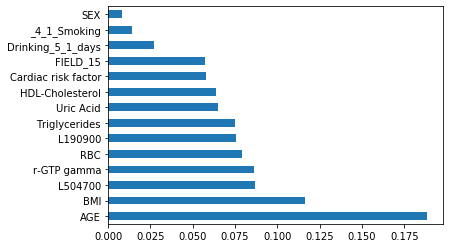

Index(['AGE', 'BMI', 'L504700', 'r-GTP gamma', 'RBC', 'L190900',
       'Triglycerides', 'Uric Acid', 'HDL-Cholesterol', 'Cardiac risk factor',
       'FIELD_15', 'Drinking_5_1_days', '_4_1_Smoking', 'SEX'],
      dtype='object')
1.0


In [18]:
ypred = rf.predict(test.iloc[:, :-1])

score = rf.score(test.iloc[:, :-1], test.iloc[:, -1])
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=test.iloc[:, :-1].columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(16).index)

print(np.sum(feat_importances.nlargest(16)))

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test.iloc[:, -1], ypred)

array([[151,  49],
       [ 55, 145]], dtype=int64)

In [20]:
print(
    "Accuracy on training set: {:.3f}".format(
        rf.score(train.iloc[:, :-1], train.iloc[:, -1])
    )
)
print(
    "Accuracy on test set: {:.3f}".format(rf.score(test.iloc[:, :-1], test.iloc[:, -1]))
)
ypred = rf.predict(test.iloc[:, :-1])

confmatrx = pd.DataFrame(confusion_matrix(test.iloc[:, -1], ypred))
confmatrx.head()

Accuracy on training set: 0.838
Accuracy on test set: 0.740


,0,1
0,151,49
1,55,145


In [21]:
from sklearn.metrics import classification_report

print(classification_report(test.iloc[:, -1], ypred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.74       200
           1       0.75      0.72      0.74       200

    accuracy                           0.74       400
   macro avg       0.74      0.74      0.74       400
weighted avg       0.74      0.74      0.74       400



In [22]:
# train.to_csv('train.csv',sep=',')
# test.to_csv('test.csv',sep=',')
# mydata.to_csv('mydata_train_test.csv',sep=',',index=False)

In [23]:
# mydata2 = data[['FIELD_1','FIELD_2','AGE', 'BMI', 'L101400', 'FIELD_15', 'L100400', 'L190900',
#                  'L190000', 'L105200', 'Cardiac risk factor', 'L504700', 'RBC',
#                  'HDL-Cholesterol', 'Uric Acid', 'fasting glucose', 'Triglycerides',
#                  'SBP',  'DBP',
#                  'CLASS'
# ]].copy().dropna()
# mydata2.to_csv('mydata_train_test.csv',sep=',',index=False)

In [24]:
import xgboost as xgb
from sklearn import metrics as m

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=randomseed)

xgb_model.fit(train.iloc[:, :-1], train.iloc[:, -1])

y_pred = xgb_model.predict((test.iloc[:, :-1]))

print(
    "Accuracy on training set: {:.3f}".format(
        xgb_model.score(train.iloc[:, :-1], train.iloc[:, -1])
    )
)
print(
    "Accuracy on test set: {:.3f}".format(xgb_model.score(test.iloc[:, :-1], test.iloc[:, -1]))
)
confmatrx = pd.DataFrame(confusion_matrix(test.iloc[:, -1], y_pred))
confmatrx.head()

Accuracy on training set: 0.707
Accuracy on test set: 0.750


,0,1
0,154,46
1,54,146


In [25]:
print(classification_report(test.iloc[:, -1], y_pred))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75       200
           1       0.76      0.73      0.74       200

    accuracy                           0.75       400
   macro avg       0.75      0.75      0.75       400
weighted avg       0.75      0.75      0.75       400



In [42]:
# train.to_csv('datasets/classification/train.txt',sep=',')
# test.to_csv('datasets/classification/test.txt',sep=',')

In [26]:
import pickle

with open('ISchemicClassifierModel_rf', 'wb') as f:
    pickle.dump(rf, f)